# Stroke prediction project

Objective is to infer stroke dataset https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/code, get machine learning model which will predict will a person have a stroke or not.

In a project we will focus on recall metric, to avoid as much as possible situations, where model will tell that user won't have a stroke, when actual danger is high 

In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import joblib
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
    cross_val_predict,
)
from sklearn.linear_model import Lasso, Ridge, LogisticRegression, BayesianRidge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    classification_report,
    mean_absolute_error,
    confusion_matrix,
    make_scorer,
    recall_score,
    precision_score,
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import analysis_functions
import warnings
import shap

sns.set_palette("colorblind")
warnings.filterwarnings("ignore")

%load_ext nb_black
%matplotlib inline

C:\Users\artur\anaconda3\envs\Stroke\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


<IPython.core.display.Javascript object>

In [2]:
df_stroke = pd.read_csv("healthcare-dataset-stroke-data.csv", index_col=None)

<IPython.core.display.Javascript object>

In [3]:
df_stroke.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


<IPython.core.display.Javascript object>

## Features Description
### Categorical features:
* gender: "Male", "Female" or "Other"
* stroke: 1 if the patient had a stroke or 0 if not
* smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"
* hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
* heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
* ever_married: No" or "Yes"
* work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
* Residence_type: "Rural" or "Urban"
* smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"
### continiuose features
* age: Age of the patient
* avg_glucose_level: Average glucose level in blood
* bmi: Body mass index

In [4]:
df_stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


<IPython.core.display.Javascript object>

In [5]:
print(
    f" Stroke dataset has {df_stroke.shape[0]} records and {df_stroke.shape[1]} features."
)

 Stroke dataset has 5110 records and 12 features.


<IPython.core.display.Javascript object>

In [6]:
df_stroke.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

<IPython.core.display.Javascript object>

Bmi feature has missing values, we wont rush to delete these records or impute values in to it , because medical data is very sensitive to data imputation. We will inspect it later

In [7]:
bool_columns = ["hypertension", "heart_disease", "stroke"]

df_stroke[bool_columns] = df_stroke[bool_columns].astype(bool)

<IPython.core.display.Javascript object>

## Stroke data set analysis

* Analysis of target variable "Stroke"
* Analysis of categorical features
* Analysis of continiuos features

## How many respondents had stroke? 

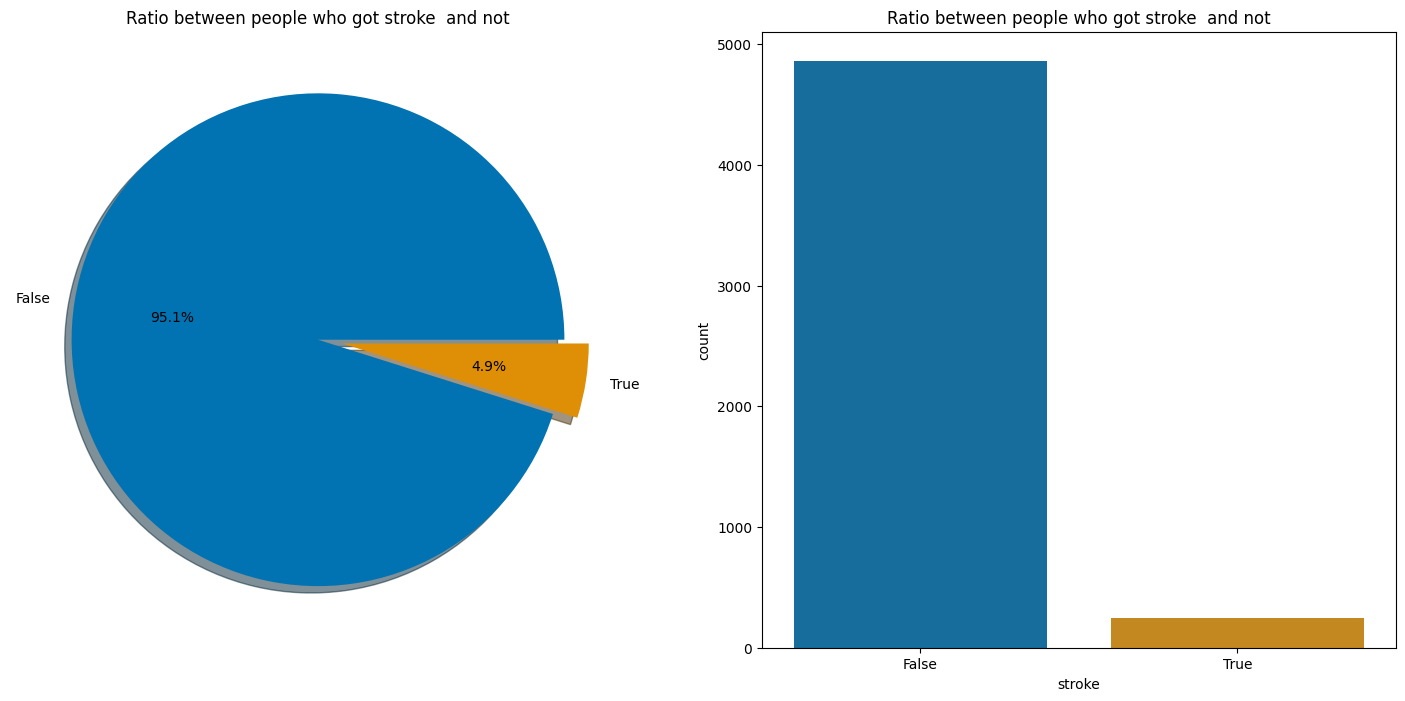

<IPython.core.display.Javascript object>

In [8]:
analysis_functions.pie_count_subplot_single(
    df_stroke["stroke"],
    title="Ratio between people who got stroke  and not",
)

Only  5% of respondents have had stroke

In [26]:
df_stroke["stroke"].value_counts()

stroke
False    4861
True      249
Name: count, dtype: int64

<IPython.core.display.Javascript object>

## Respondents gender  and how many had  stroke between those groups 

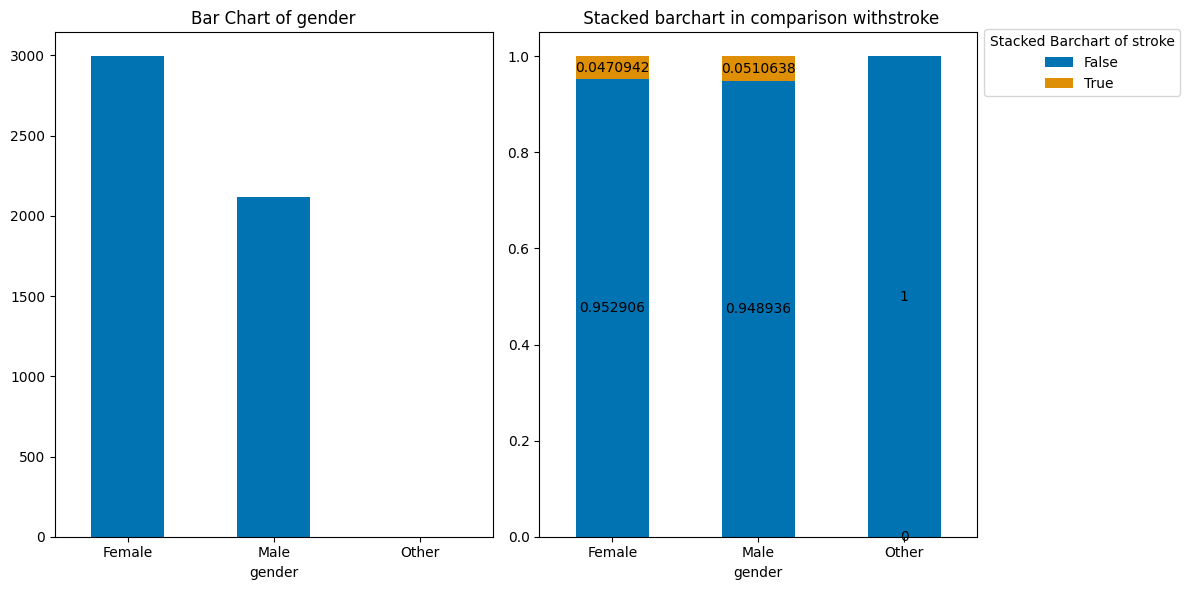

<IPython.core.display.Javascript object>

In [27]:
analysis_functions.plot_bar_and_stacked_bar(
    df_stroke,
    x_column="gender",
    hue_column="stroke",
    figsize=(12, 6),
)

In our dataset we have more females than males and we can see that males has slighly more often stroke than females

## Has our respondents heart disease and how many had stroke between these groups 

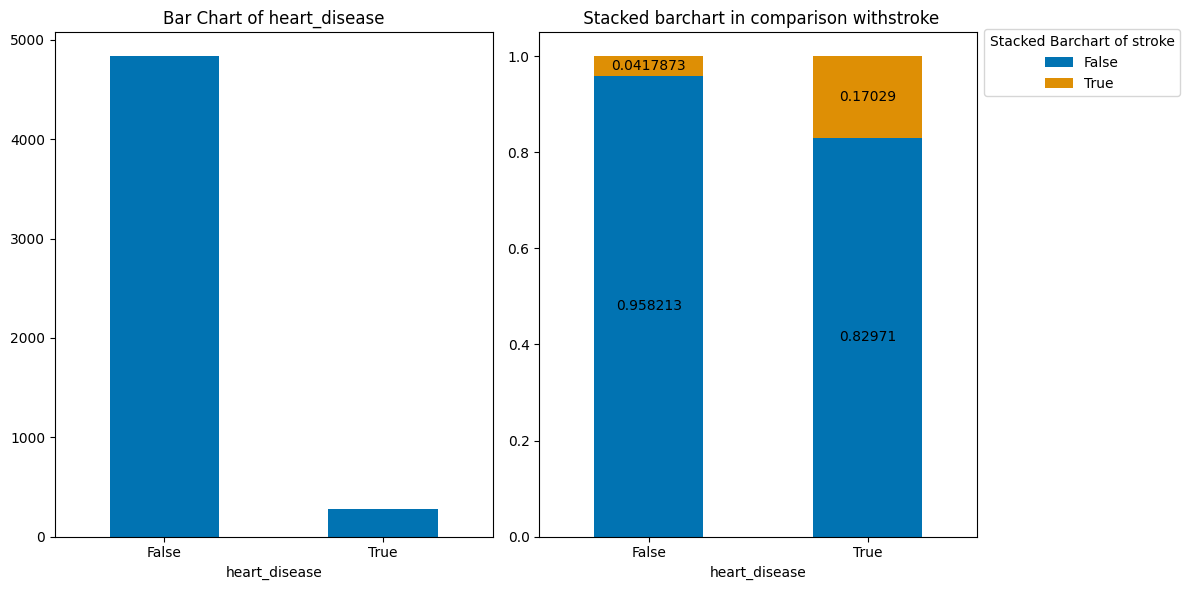

<IPython.core.display.Javascript object>

In [28]:
analysis_functions.plot_bar_and_stacked_bar(
    df_stroke,
    x_column="heart_disease",
    hue_column="stroke",
    figsize=(12, 6),
)

Much more respondents doesn't have a heart disease. We can see that bigger proportion of people with heart disease  had a stroke than people without heart dosease

## Have respondents ever been married, and how many had stroke between these groups? 

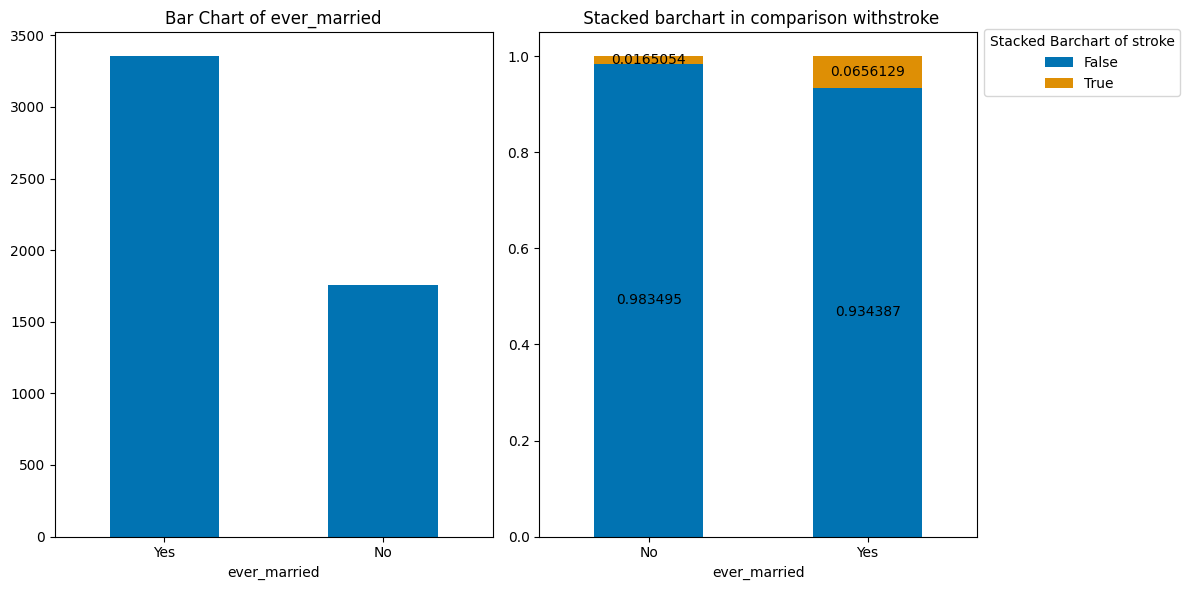

<IPython.core.display.Javascript object>

In [29]:
analysis_functions.plot_bar_and_stacked_bar(
    df_stroke,
    x_column="ever_married",
    hue_column="stroke",
    figsize=(12, 6),
)

Almost twice more respondents has ever married and in group of  who hasnt ever married has biger proportion of people with stroke



##  Work type of our respondents and how many had stroke between these groups

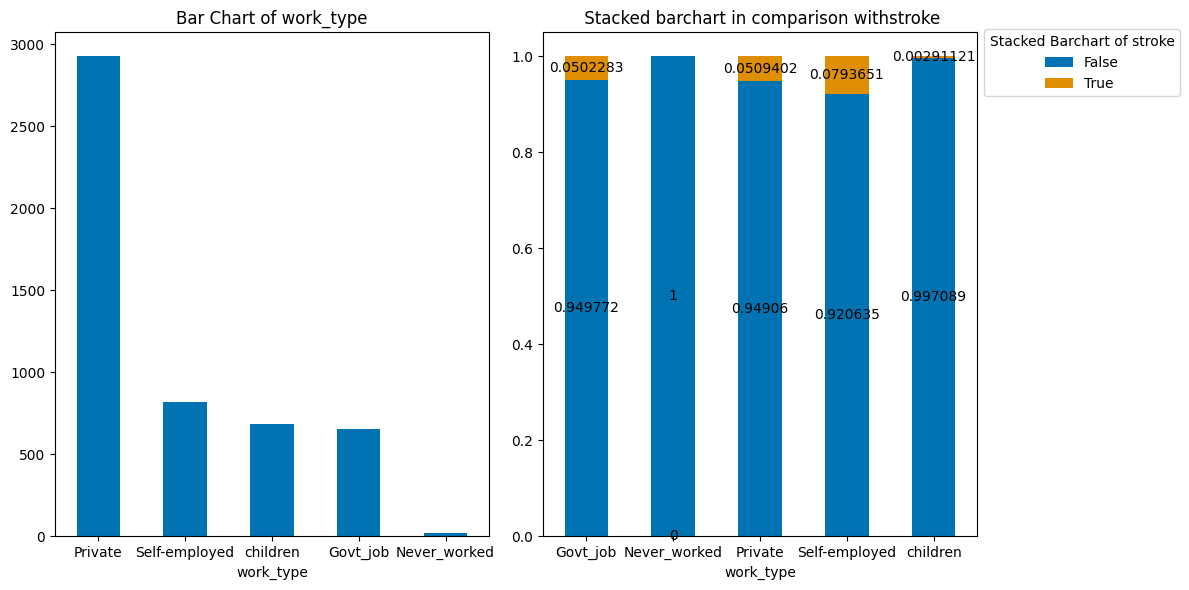

<IPython.core.display.Javascript object>

In [30]:
analysis_functions.plot_bar_and_stacked_bar(
    df_stroke,
    x_column="work_type",
    hue_column="stroke",
    figsize=(12, 6),
)

Most of respondents works in a private sector. The biggest ratio of stroke has respondents , who are self_employed

## Respondents residence type  and proportion of people with stroke in these groups

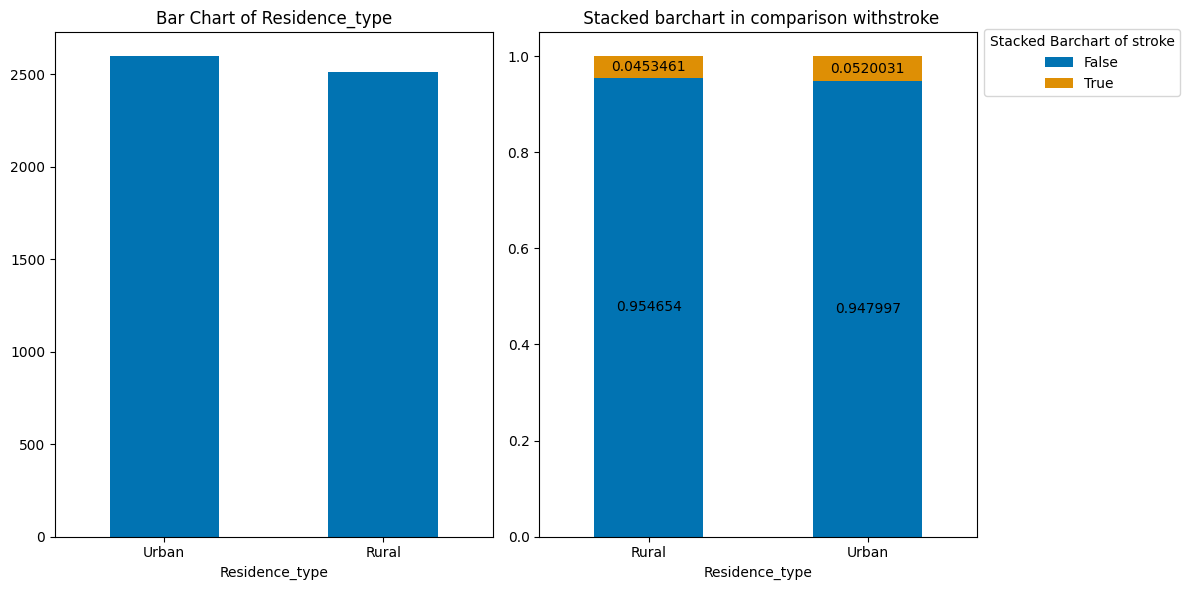

<IPython.core.display.Javascript object>

In [31]:
analysis_functions.plot_bar_and_stacked_bar(
    df_stroke,
    x_column="Residence_type",
    hue_column="stroke",
    figsize=(12, 6),
)

More respondents live in urban area, and we can see that it has slightly bigger proportion of people with stroke than respondents from rural areas


## Smoking status of our respondents and ratio of how many had stroke between these groups"

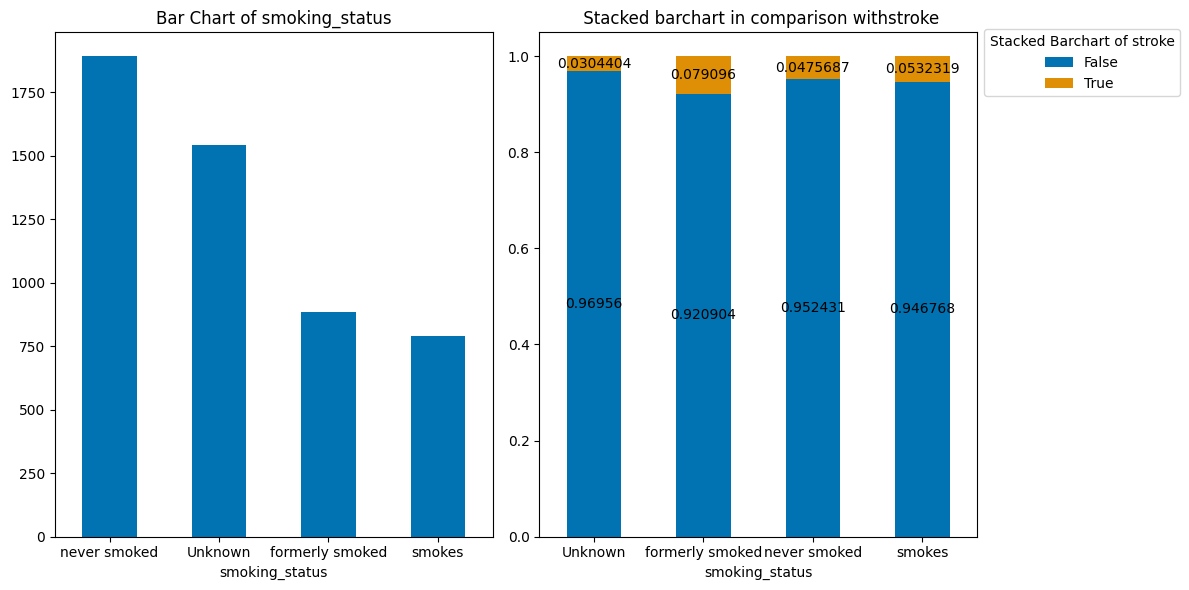

<IPython.core.display.Javascript object>

In [32]:
analysis_functions.plot_bar_and_stacked_bar(
    df_stroke,
    x_column="smoking_status",
    hue_column="stroke",
    figsize=(12, 6),
)

Most of the respondens hasn't ever smoked. Interesting, biggest proportion of people who had stroke is in group, which has formerly smoked

# Respondents with and without hypertension and proportion of people with stroke in these groups

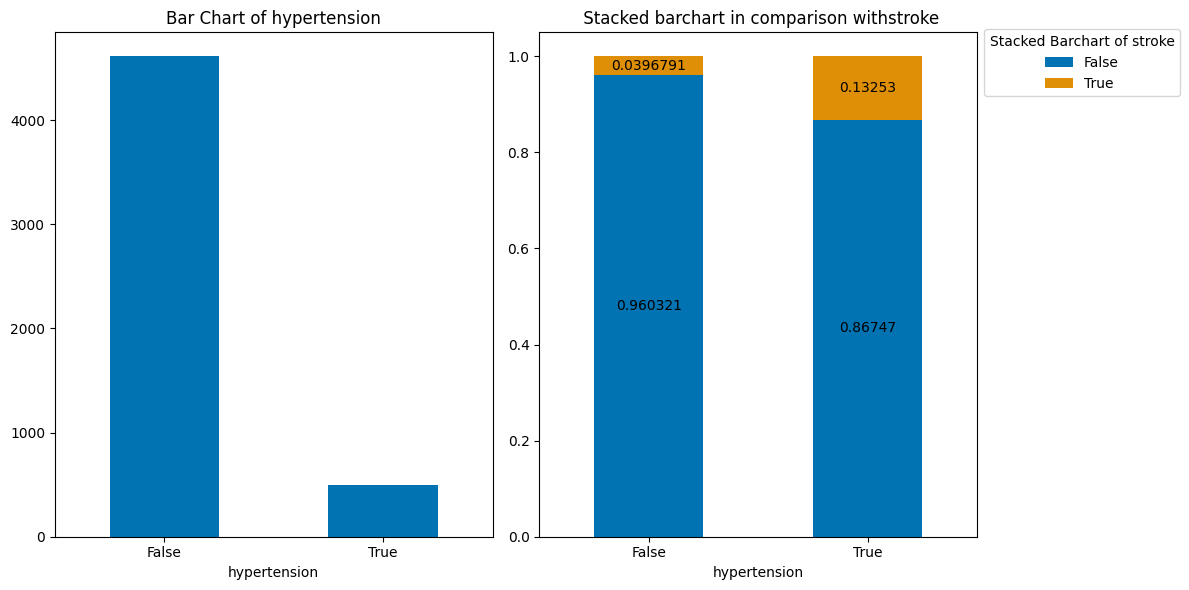

<IPython.core.display.Javascript object>

In [33]:
analysis_functions.plot_bar_and_stacked_bar(
    df_stroke,
    x_column="hypertension",
    hue_column="stroke",
    figsize=(12, 6),
)

Much more respondents doesn't have hyper tension.  Ratio of people with stroke between those who had hypertension is 3 times higher than without hypertension

## Numerical features analysis

In [34]:
# Filter data for two groups: with stroke and without stroke
with_stroke = df_stroke[df_stroke["stroke"] == 1]
without_stroke = df_stroke[df_stroke["stroke"] == 0]

# Print the number of data points in each group
print("Number of data points with stroke:", len(with_stroke))
print("Number of data points without stroke:", len(without_stroke))

Number of data points with stroke: 249
Number of data points without stroke: 4861


<IPython.core.display.Javascript object>

In [35]:
with_stroke.describe()

,id,age,avg_glucose_level,bmi
count,249.000000,249.000000,249.000000,209.000000
mean,37115.068273,67.728193,132.544739,30.471292
std,21993.344872,12.727419,61.921056,6.329452
min,210.000000,1.320000,56.110000,16.900000
25%,17013.000000,59.000000,79.790000,26.400000
50%,36706.000000,71.000000,105.220000,29.700000
75%,56669.000000,78.000000,196.710000,33.700000
max,72918.000000,82.000000,271.740000,56.600000


<IPython.core.display.Javascript object>

In [36]:
without_stroke.describe()

,id,age,avg_glucose_level,bmi
count,4861.000000,4861.000000,4861.000000,4700.000000
mean,36487.236371,41.971545,104.795513,28.823064
std,21120.133386,22.291940,43.846069,7.908287
min,67.000000,0.080000,55.120000,10.300000
25%,17762.000000,24.000000,77.120000,23.400000
50%,36958.000000,43.000000,91.470000,28.000000
75%,54497.000000,59.000000,112.830000,33.100000
max,72940.000000,82.000000,267.760000,97.600000


<IPython.core.display.Javascript object>

## Continiuos feature age


<Axes: xlabel='age', ylabel='Count'>

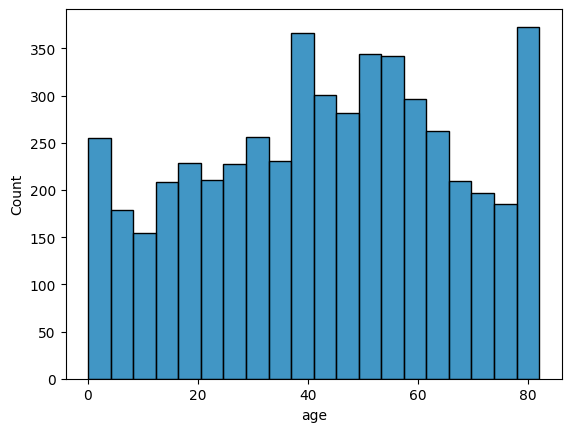

<IPython.core.display.Javascript object>

In [37]:
sns.histplot(df_stroke, x="age")

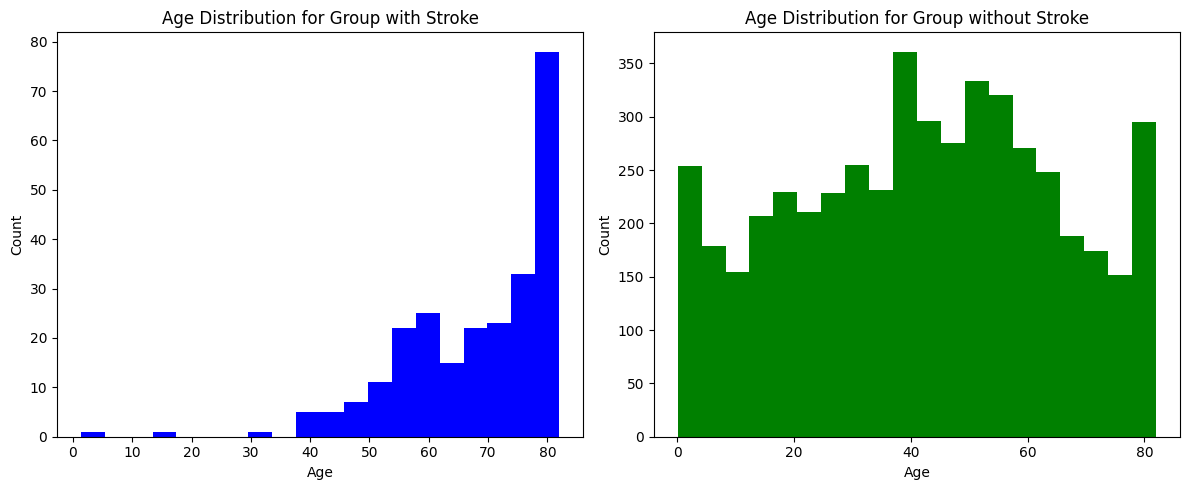

<IPython.core.display.Javascript object>

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


# Plot histograms for both groups in separate subplots with real numbers on the x-axis
ax1.hist(with_stroke["age"], bins=20, color="blue")
ax1.set_xlabel("Age")
ax1.set_ylabel("Count")
ax1.set_title("Age Distribution for Group with Stroke")

ax2.hist(without_stroke["age"], bins=20, color="green")
ax2.set_xlabel("Age")
ax2.set_ylabel("Count")
ax2.set_title("Age Distribution for Group without Stroke")

# Adjust layout
plt.tight_layout()

# Show the plots

Stroke risk increases from 40 years

## Average glucosis level

<Axes: xlabel='avg_glucose_level', ylabel='Count'>

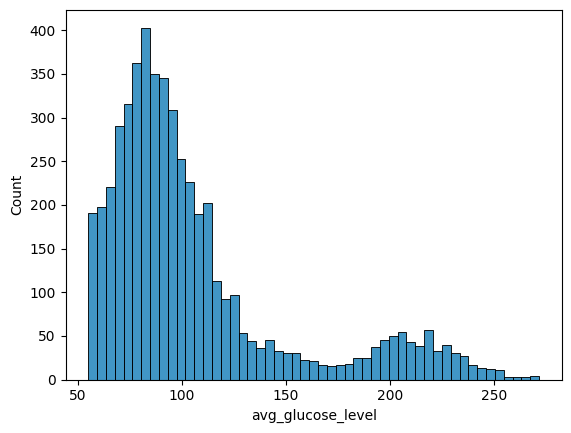

<IPython.core.display.Javascript object>

In [39]:
sns.histplot(df_stroke, x="avg_glucose_level")

Distribution of average glucosis level is right skewed , with peak around  75

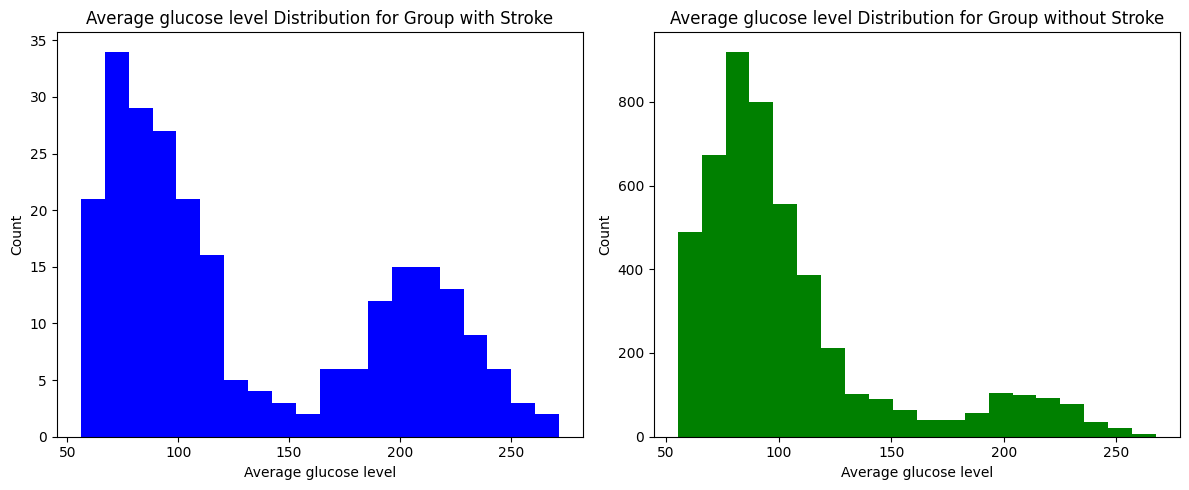

<IPython.core.display.Javascript object>

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


# Plot histograms for both groups in separate subplots with real numbers on the x-axis
ax1.hist(with_stroke["avg_glucose_level"], bins=20, color="blue")
ax1.set_xlabel("Average glucose level")
ax1.set_ylabel("Count")
ax1.set_title("Average glucose level Distribution for Group with Stroke")

ax2.hist(without_stroke["avg_glucose_level"], bins=20, color="green")
ax2.set_xlabel("Average glucose level")
ax2.set_ylabel("Count")
ax2.set_title("Average glucose level Distribution for Group without Stroke")

# Adjust layout
plt.tight_layout()

Average glukosis levels between people with and without stroke is almost identical, for people with stroke average glucosis level distribution is more right skewed and bigger proportion is between 150 and 250

# Bmi

<Axes: xlabel='bmi', ylabel='Count'>

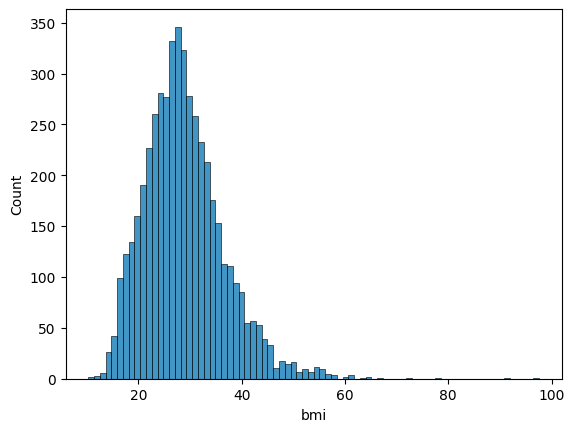

<IPython.core.display.Javascript object>

In [41]:
sns.histplot(df_stroke, x="bmi")

Bmi looks to have a normal distribution , with one peak, slightly  right skewed

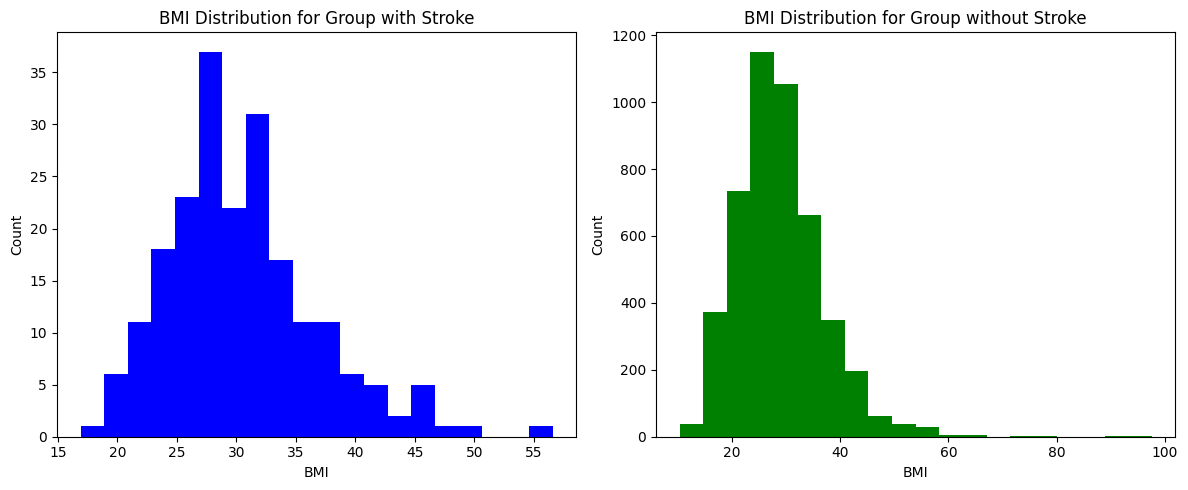

<IPython.core.display.Javascript object>

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


# Plot histograms for both groups in separate subplots with real numbers on the x-axis
ax1.hist(with_stroke["bmi"], bins=20, color="blue")
ax1.set_xlabel("BMI")
ax1.set_ylabel("Count")
ax1.set_title("BMI Distribution for Group with Stroke")

ax2.hist(without_stroke["bmi"], bins=20, color="green")
ax2.set_xlabel("BMI")
ax2.set_ylabel("Count")
ax2.set_title("BMI Distribution for Group without Stroke")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Distributions are very simmilar , just people with stroke has bmi till 55, without stroke , there is values and greater than 55


In [43]:
with_stroke.isna().sum()

id                    0
gender                0
age                   0
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
avg_glucose_level     0
bmi                  40
smoking_status        0
stroke                0
dtype: int64

<IPython.core.display.Javascript object>

In [44]:
without_stroke.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  161
smoking_status         0
stroke                 0
dtype: int64

<IPython.core.display.Javascript object>

In [5]:
bool_columns = df_stroke.select_dtypes(include=["bool"]).columns
for column in bool_columns:
    df_stroke[column] = df_stroke[column].astype(int)
df_stroke.update(df_stroke)

<IPython.core.display.Javascript object>

In [6]:
df_stroke["ever_married"] = df_stroke["ever_married"].map({"No": 0, "Yes": 1})

<IPython.core.display.Javascript object>

In [7]:
df_stroke["ever_married"] = df_stroke["ever_married"].astype(int)

<IPython.core.display.Javascript object>

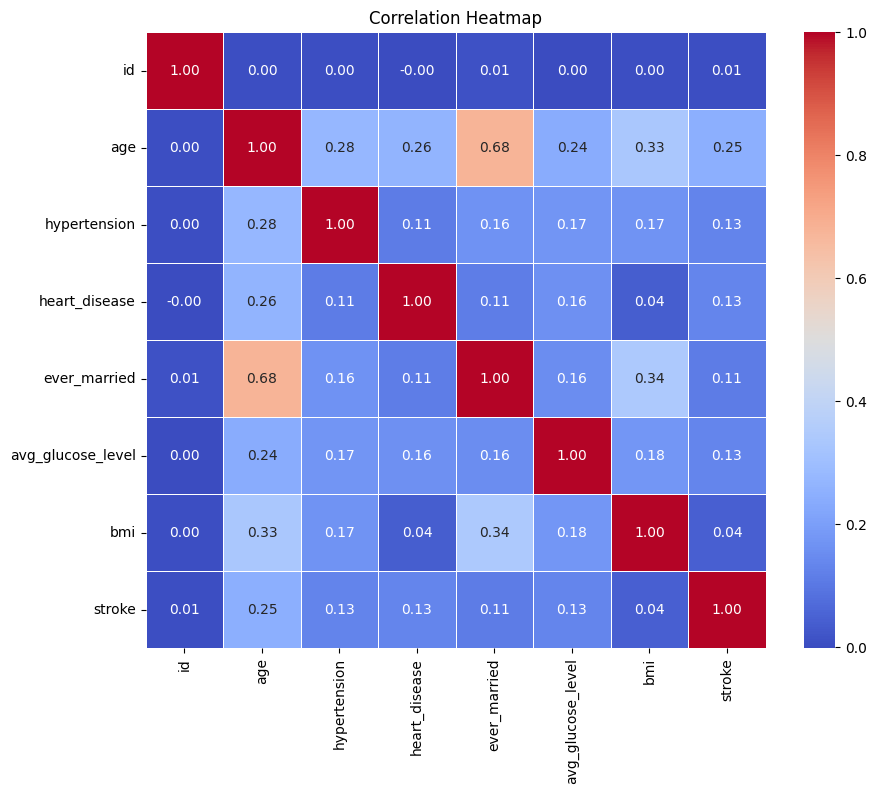

<IPython.core.display.Javascript object>

In [8]:
# Select only numeric columns
numeric_columns = df_stroke.select_dtypes(include=["number"])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))  # You can adjust the figsize as needed
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Add a title
plt.title("Correlation Heatmap")

# Show the heatmap
plt.show()

Only age and ever married features has high correlation (0.68)

## Data Preparation for modeling (Preprocessing)

Bmi feature has missing values. Medical data is sensitive to sintetic data imputation, that's why , we will leave them  and create models that handle it natively

In [9]:
numerical_features = df_stroke.select_dtypes(include=['number']).columns.tolist()
categorical_features = df_stroke.select_dtypes(exclude=['number']).columns.tolist()


<IPython.core.display.Javascript object>

In [14]:
numerical_features.remove('id')

<IPython.core.display.Javascript object>

In [15]:
numerical_features

['age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'avg_glucose_level',
 'bmi',
 'stroke']

<IPython.core.display.Javascript object>

In [21]:
categorical_features

['gender', 'work_type', 'Residence_type', 'smoking_status']

<IPython.core.display.Javascript object>

In [38]:
# Remove the "stroke" column from the list if it exists
if "stroke" in categorical_features:
    categorical_features.remove("stroke")

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")

# Fit and transform the categorical features
encoded_features = encoder.fit_transform(df_stroke[categorical_features])

# Get the feature names from the encoder
feature_names = encoder.get_feature_names_out(input_features=categorical_features)

# Create a DataFrame with the encoded features and feature names
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)


<IPython.core.display.Javascript object>

In [46]:
encoded_df

,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5106,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5107,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5108,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


<IPython.core.display.Javascript object>

In [47]:
# Concatenate the encoded features with the original DataFrame
df_stroke_encoded = pd.concat(
    [df_stroke.drop(columns=categorical_features), encoded_df], axis=1
)

<IPython.core.display.Javascript object>

In [48]:
test_data = df_stroke_encoded.sample(frac=0.1, random_state=42)

<IPython.core.display.Javascript object>

In [42]:
test_data["stroke"].value_counts()

stroke
0    483
1     28
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [43]:
df_stroke_encoded["stroke"].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

<IPython.core.display.Javascript object>

# Modeling

Because of the missing values , in a project is used Gradient boosting models , that handles missing values : "XGBOOST" , "LightGBM", "HistGradientBoosting"

### Data spliting , target and predictor features initialization 

In [44]:
X = df_stroke_encoded.drop(
    columns=["stroke"]
)  # Include all other columns except 'stroke'
# Adjust column names as needed
y = df_stroke_encoded["stroke"]

<IPython.core.display.Javascript object>

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

<IPython.core.display.Javascript object>

### Hyper parameters tuning for XGB , LGBM and HistGradientBosting classification models 

Finding best parameters on recall macro  accuracy metric, because we want to avoid as much as possible situations where , model will tell that there is no stroke danger , when it will be 

In [46]:
param_grid_xgboost = {
    "n_estimators": [500, 200, 100],
    "learning_rate": [
       0.01, 0.1,0.2
    ],
    "max_depth": [6, 8, 5, 4],
    "reg_alpha": [100.0, 0.0, 5.0, 20.0, 50.0],
    "scale_pos_weight": [21, 19],
    "booster": [
        "gbtree",
    ],
    "gamma": [2, 5, 10, 20],
    "eval_metric": ["logloss"],
    "warm_start": [True, False],
}

<IPython.core.display.Javascript object>

In [47]:
gs_xgb = GridSearchCV(
    estimator=XGBClassifier(
        objective="binary:logistic", seed=42, subsample=0.9, eval_metric="logloss"
    ),
    param_grid=param_grid_xgboost,
    n_jobs=10,
    cv=5,
    scoring="recall_macro",
    verbose=2,
)
gs_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'booster': ['gbtree'], 'eval_metric': ['logloss'],
                         'gamma': [2, 5, 10, 20], 'learning_rate': [0.1],
                         'max_depth': [6, 8, 5, 4],
                         'n_estimators': [500, 200, 100],
                         'reg_alpha': [100.0, 0.0, 5.0, 20.0, 50.0],
                         'scale_pos_weight': [21, 19],
                         'warm_start': [True, False]},
             scoring='recall_macro', verbose=2)

<IPython.core.display.Javascript object>

In [48]:
best_recall_macro_score = gs_xgb.best_score_
print("Best recall_macro score:", best_recall_macro_score)

Best recall_macro score: 0.7837990422694793


<IPython.core.display.Javascript object>

In [49]:
xgb_best_params = gs_xgb.best_params_
print("Best Parameters:", xgb_best_params)

Best Parameters: {'booster': 'gbtree', 'eval_metric': 'logloss', 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'reg_alpha': 100.0, 'scale_pos_weight': 19, 'warm_start': True}


<IPython.core.display.Javascript object>

In [59]:
param_grid_lgbm = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [10],
    "min_child_samples": [10],
    "subsample": [0.9],
    "class_weight": ["balanced"],
    "scale_pos_weight": [27, 20],
    "reg_alpha": [10.0],
    "gamma": [
        2,
    ],
    "num_leaves": [
        15,
    ],
    "eval_metric": ["logloss"],
}

gs_lgb = GridSearchCV(
    estimator=LGBMClassifier(
        objective="binary", seed=42, subsample=0.9, eval_metric="logloss"
    ),
    param_grid=param_grid_lgbm,
    n_jobs=4,
    cv=5,
    scoring="recall_macro",
    verbose=2,
)

gs_lgb.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 199, number of negative: 3889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

GridSearchCV(cv=5,
             estimator=LGBMClassifier(eval_metric='logloss', objective='binary',
                                      seed=42, subsample=0.9),
             n_jobs=4,
             param_grid={'class_weight': ['balanced'],
                         'eval_metric': ['logloss'], 'gamma': [2],
                         'learning_rate': [0.1], 'max_depth': [10],
                         'min_child_samples': [10], 'n_estimators': [100],
                         'num_leaves': [15], 'reg_alpha': [10.0],
                         'scale_pos_weight': [27, 20], 'subsample': [0.9]},
             scoring='recall_macro', verbose=2)

<IPython.core.display.Javascript object>

In [60]:
best_recall_macro_score = gs_lgb.best_score_
print("Best recall_macro score:", best_recall_macro_score)

Best recall_macro score: 0.7792075652872568


<IPython.core.display.Javascript object>

In [61]:
lgb_best_params = gs_lgb.best_params_
print("Best Parameters:", lgb_best_params)

Best Parameters: {'class_weight': 'balanced', 'eval_metric': 'logloss', 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 10, 'n_estimators': 100, 'num_leaves': 15, 'reg_alpha': 10.0, 'scale_pos_weight': 27, 'subsample': 0.9}


<IPython.core.display.Javascript object>

In [69]:
param_grid_histgb = {
    "learning_rate": [0.1, 0.2],
    "max_depth": [5, 10, 13],
    "l2_regularization": [0.2, 0.1],
    "max_bins": [50, 125, 255],
    "class_weight": [None, "balanced"],
}

gs_hist = GridSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=42),
    param_grid=param_grid_histgb,
    n_jobs=4,
    cv=5,
    scoring="recall_macro",
    verbose=2,
)

gs_hist.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=42),
             n_jobs=4,
             param_grid={'class_weight': [None, 'balanced'],
                         'l2_regularization': [0.2, 0.1],
                         'learning_rate': [0.1, 0.2],
                         'max_bins': [50, 125, 255], 'max_depth': [5, 10, 13]},
             scoring='recall_macro', verbose=2)

<IPython.core.display.Javascript object>

In [74]:
best_recall_macro_score = gs_hist.best_score_
print("Best recall_macro score:", best_recall_macro_score)

Best recall_macro score: 0.6838811721128794


<IPython.core.display.Javascript object>

In [75]:
hist_best_params = gs_hist.best_params_
print("Best Parameters:", hist_best_params)

Best Parameters: {'class_weight': 'balanced', 'l2_regularization': 0.2, 'learning_rate': 0.1, 'max_bins': 125, 'max_depth': 5}


<IPython.core.display.Javascript object>

### Kfold validation of models with best hyper parameters , after hyper parameters tuning 

In [76]:
# Define the number of splits for k-fold cross-validation
n_splits = 5
random_state = 22
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)


xgb1 = XGBClassifier(**xgb_best_params)
lgb1 = LGBMClassifier(**lgb_best_params)
histgb1 = HistGradientBoostingClassifier(**hist_best_params)

# Lists of classifiers and models
models = [
    xgb1,
    lgb1,
    histgb1,
]

# Update the classifiers list accordingly
classifiers = [
    "XGB1",
    "LGB1",
    "HistGB1",
    # Add more classifiers here as needed
]

# Lists to store results
xyz = []
recall_macro = []  # Store recall_macro scores

# Initialize a list to store confusion matrices
confusion_matrices = []

# Loop through each model, perform cross-validation, and store results
for model in models:
    cv_result = cross_val_score(model, X, y, cv=kfold, scoring="recall_macro")
    xyz.append(cv_result.mean())

    # Calculate recall_macro scores and store them
    recall_macro_scores = []
    model_confusion_matrices = []  # Store confusion matrices for each fold
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        recall_macro_scores.append(recall_score(y_test, y_pred, average="macro"))

        # Calculate and store the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        model_confusion_matrices.append(cm)

    # Calculate the average confusion matrix across folds
    average_confusion_matrix = sum(model_confusion_matrices) / len(
        model_confusion_matrices
    )
    confusion_matrices.append(average_confusion_matrix)

    recall_macro.append(np.mean(recall_macro_scores))

# Create a DataFrame to display the results
new_models_dataframe3 = pd.DataFrame(
    {"CV recall_macro Mean": xyz, "Recall_macro mean": recall_macro}, index=classifiers
)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 194, number of negative: 3894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 194, number of negative: 3894
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma


<IPython.core.display.Javascript object>

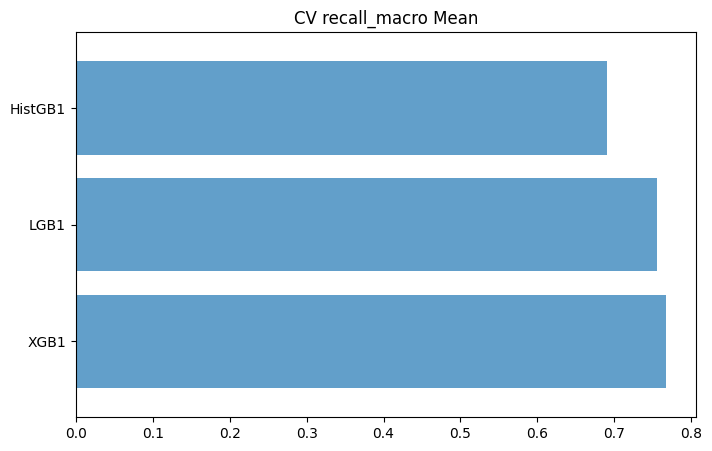

<IPython.core.display.Javascript object>

In [77]:
sorted_df = new_models_dataframe3.sort_values(
    by="CV recall_macro Mean", ascending=False
)

# Create a figure and axes for the bar chart
fig, ax = plt.subplots(figsize=(8, 5))

# Bar plot of "CV Mean" values
sorted_df["CV recall_macro Mean"].plot.barh(
    width=0.8, ax=ax, color="tab:blue", alpha=0.7
)

# Set title
plt.title("CV recall_macro Mean")

# Show the bar chart
plt.show()

Kfold validation shows that XGBOOST model performs best, has best macro_recall score

## Confusion matrix of models performance at  kfol validation

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 199, number of negative: 3889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma


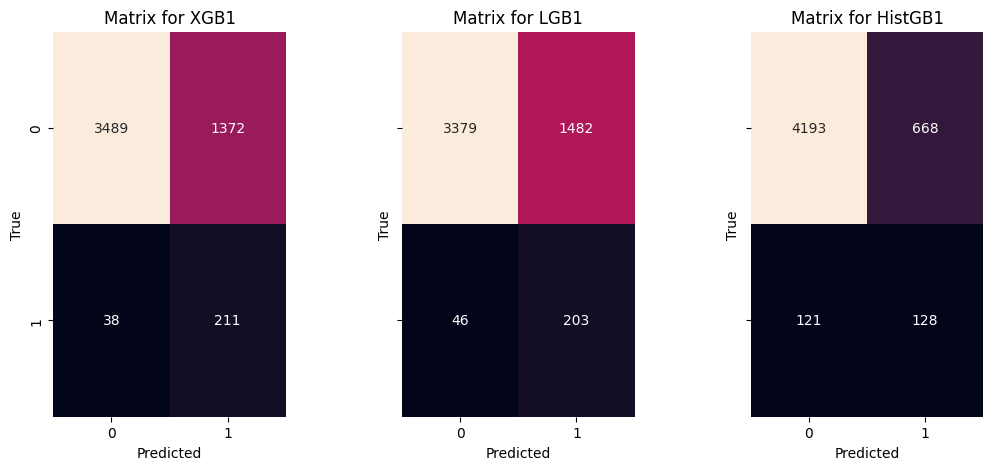

<IPython.core.display.Javascript object>

In [82]:
# Create subplots with adjusted aspect ratio
n_classifiers = len(models)
n_cols = min(n_classifiers, 3)  # Limit to a maximum of 3 columns

f, ax = plt.subplots(1, n_cols, figsize=(12, 5), squeeze=False, sharey="row")

# Loop through classifiers
for i, clf in enumerate(models):
    # Predict using cross-validation
    y_pred = cross_val_predict(clf, X, y, cv=5)

    # Calculate confusion matrix
    cm = confusion_matrix(y, y_pred)

    # Create a heatmap for the confusion matrix with labels
    col_idx = i % n_cols
    heatmap = sns.heatmap(cm, annot=True, fmt="2.0f", ax=ax[0, col_idx], cbar=False)
    heatmap.set_aspect("auto")  # Set the aspect ratio after creating the heatmap
    ax[0, col_idx].set_title(f"Matrix for {classifiers[i]}")

    # Add labels for the axes
    ax[0, col_idx].set_xlabel("Predicted")
    ax[0, col_idx].set_ylabel("True")

# Adjust subplot spacing
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Show the plot
plt.show()

At this point XGBOOST clasification model works best

## Creation of a models with best hyperparameters  found, test on validation data set 

In [53]:
lgb1 = LGBMClassifier(**lgb_best_params)

<IPython.core.display.Javascript object>

In [62]:
lgb1.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="logloss",
)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 199, number of negative: 3889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 19
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain

LGBMClassifier(class_weight='balanced', eval_metric='logloss', gamma=2,
               max_depth=10, min_child_samples=10, num_leaves=15,
               reg_alpha=10.0, scale_pos_weight=27, subsample=0.9)

<IPython.core.display.Javascript object>

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma


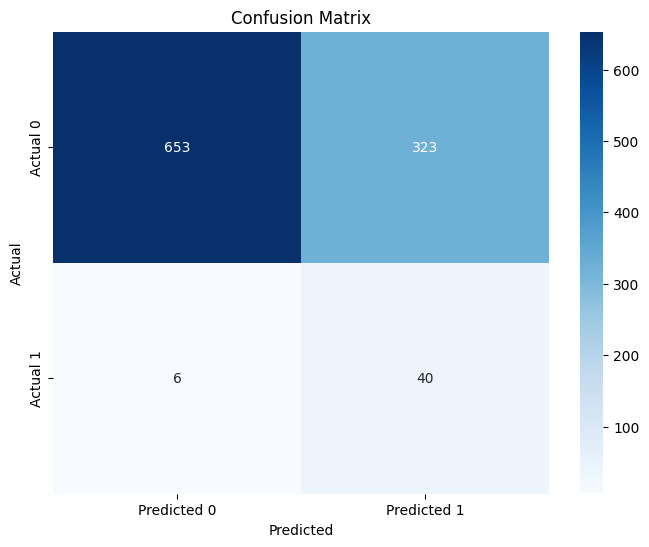

<IPython.core.display.Javascript object>

In [118]:
y_pred_lgb1 = lgb1.predict(X_test)

cm = confusion_matrix(y_test, y_pred_lgb1)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [94]:
# Generate a classification report
report = classification_report(y_test, y_pred_lgb1)

# Print the classification report
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.67      0.80       976
           1       0.11      0.87      0.20        46

    accuracy                           0.68      1022
   macro avg       0.55      0.77      0.50      1022
weighted avg       0.95      0.68      0.77      1022



<IPython.core.display.Javascript object>

In [99]:
xgb2 = XGBClassifier(**xgb_best_params)

<IPython.core.display.Javascript object>

In [104]:
xgb2.fit(
    X_train,
    y_train,
    verbose=True,
    early_stopping_rounds=10,
    eval_set=[(X_test, y_test)],
)

[0]	validation_0-logloss:0.66244
[1]	validation_0-logloss:0.64022
[2]	validation_0-logloss:0.61920
[3]	validation_0-logloss:0.60481
[4]	validation_0-logloss:0.59105
[5]	validation_0-logloss:0.58118
[6]	validation_0-logloss:0.57367
[7]	validation_0-logloss:0.56469
[8]	validation_0-logloss:0.55869
[9]	validation_0-logloss:0.55299
[10]	validation_0-logloss:0.54664
[11]	validation_0-logloss:0.54431
[12]	validation_0-logloss:0.53893
[13]	validation_0-logloss:0.53563
[14]	validation_0-logloss:0.53302
[15]	validation_0-logloss:0.52924
[16]	validation_0-logloss:0.52728
[17]	validation_0-logloss:0.52323
[18]	validation_0-logloss:0.52164
[19]	validation_0-logloss:0.51922
[20]	validation_0-logloss:0.51788
[21]	validation_0-logloss:0.51469
[22]	validation_0-logloss:0.51328
[23]	validation_0-logloss:0.51198
[24]	validation_0-logloss:0.50958
[25]	validation_0-logloss:0.50905
[26]	validation_0-logloss:0.50805
[27]	validation_0-logloss:0.50708
[28]	validation_0-logloss:0.50479
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

<IPython.core.display.Javascript object>

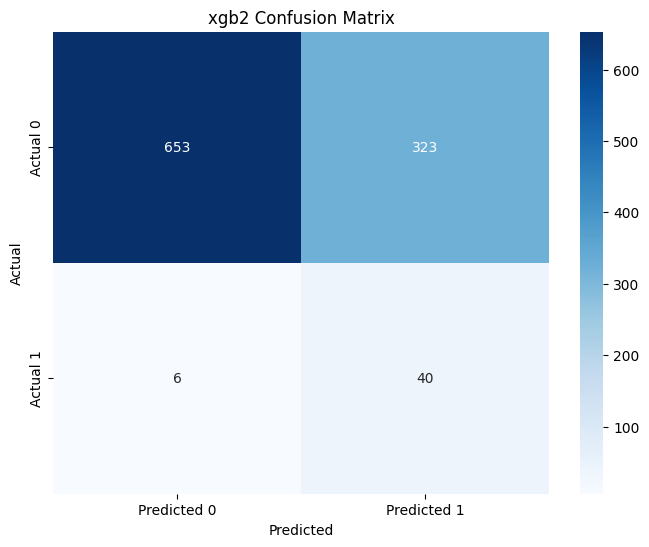

<IPython.core.display.Javascript object>

In [119]:
y_pred_xgb2 = xgb2.predict(X_test)

cm = confusion_matrix(y_test, y_pred_lgb1)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("xgb2 Confusion Matrix")
plt.show()

In [106]:
# Generate a classification report
report_xgb2 = classification_report(y_test, y_pred_xgb2)

# Print the classification report
print("Classification Report:\n", report_xgb2)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.71      0.82       976
           1       0.12      0.83      0.20        46

    accuracy                           0.71      1022
   macro avg       0.55      0.77      0.51      1022
weighted avg       0.95      0.71      0.80      1022



<IPython.core.display.Javascript object>

Identical confusion matrix's we got, after this step won't select best model, will do it after test on separate test data sample 

In [124]:
test_data

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
4688,31.0,0,0,0,64.85,23.0,0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4478,40.0,0,0,1,65.29,28.3,0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3849,8.0,0,0,0,74.42,22.5,0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4355,79.0,1,0,1,76.64,19.5,0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3826,75.0,0,0,1,94.77,27.2,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,70.0,0,0,1,69.04,35.9,0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1833,14.0,0,0,0,92.86,20.7,0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3411,26.0,0,0,1,88.79,24.9,0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
350,79.0,1,1,1,200.28,30.0,0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


<IPython.core.display.Javascript object>

In [120]:
# Assuming X_test has both predictor features and target variable
X_test_features = test_data.drop("stroke", axis=1)  # Remove the target variable

# Make predictions using xgb2
xgb_predictions = xgb2.predict(X_test_features)

# Make predictions using lgb1
lgb_predictions = lgb1.predict(X_test_features)

# If you're working with binary classification and want class probabilities for xgboost
xgb_probabilities = xgb2.predict_proba(X_test_features)[:, 1]

# If you're working with binary classification and want class probabilities for lightgbm
lgb_probabilities = lgb1.predict_proba(X_test_features)[:, 1]

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma


<IPython.core.display.Javascript object>

In [129]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
)


X_test_features = test_data.drop("stroke", axis=1)  # Remove the target variable
y_test_actual = test_data["stroke"]

# Make predictions using xgb2
xgb_predictions = xgb2.predict(X_test_features)

# Make predictions using lgb1
lgb_predictions = lgb1.predict(X_test_features)

# Evaluate xgboost predictions
print("XGBoost Metrics:")
print("Accuracy:", accuracy_score(y_test_actual, xgb_predictions))
print("Precision:", precision_score(y_test_actual, xgb_predictions))
print("Recall:", recall_score(y_test_actual, xgb_predictions))
print("F1 Score:", f1_score(y_test_actual, xgb_predictions))

# Evaluate lightgbm predictions
print("\nLightGBM Metrics:")
print("Accuracy:", accuracy_score(y_test_actual, lgb_predictions))
print("Precision:", precision_score(y_test_actual, lgb_predictions))
print("Recall:", recall_score(y_test_actual, lgb_predictions))
print("F1 Score:", f1_score(y_test_actual, lgb_predictions))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
XGBoost Metrics:
Accuracy: 0.7338551859099804
Precision: 0.14935064935064934
Recall: 0.8214285714285714
F1 Score: 0.25274725274725274

LightGBM Metrics:
Accuracy: 0.6966731898238747
Precision: 0.14917127071823205
Recall: 0.9642857142857143
F1 Score: 0.25837320574162675


<IPython.core.display.Javascript object>

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma


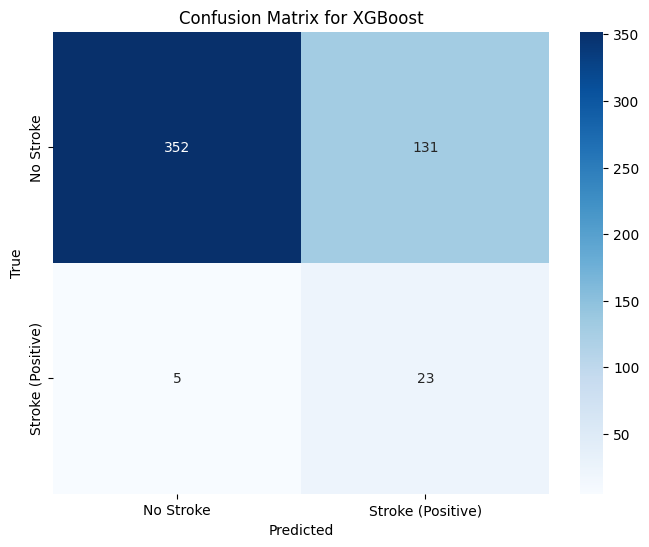

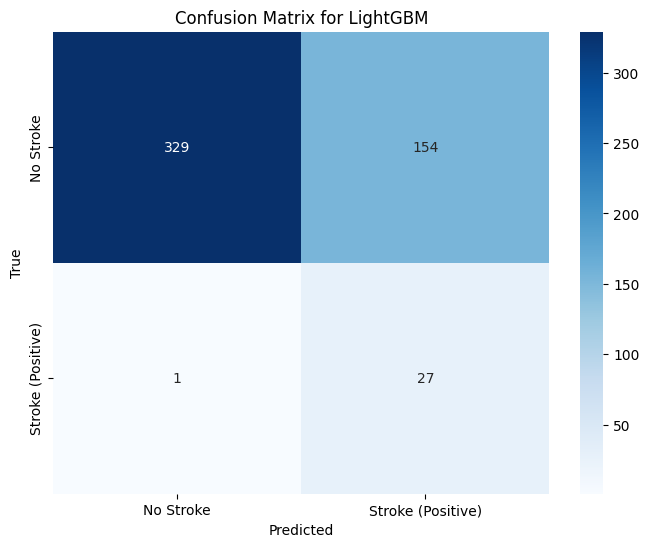

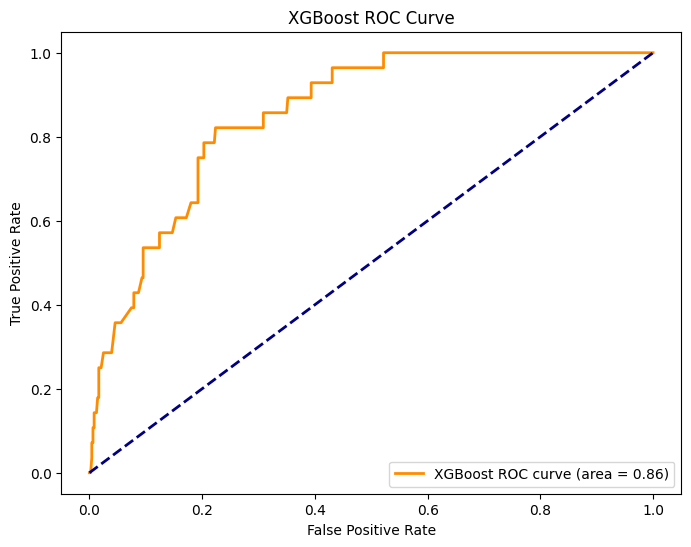

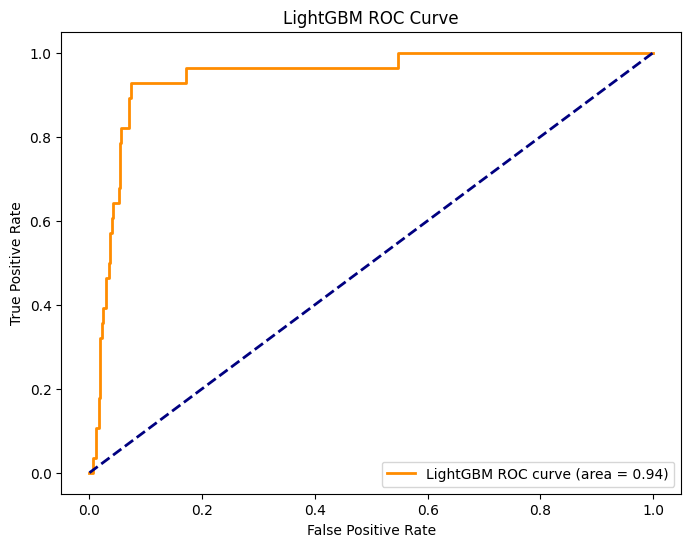

<IPython.core.display.Javascript object>

In [131]:

def plot_confusion_matrix(y_true, y_pred, model_name, labels=["Negative", "Positive"]):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Plot ROC curve function
def plot_roc_curve(y_true, y_probs, model_name=""):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label=f"{model_name} ROC curve (area = {roc_auc:.2f})",
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")
    plt.legend(loc="lower right")
    plt.show()


# Make predictions with probabilities using xgb2
xgb_probabilities = xgb2.predict_proba(X_test_features)[:, 1]

# Make predictions with probabilities using lgb1
lgb_probabilities = lgb1.predict_proba(X_test_features)[:, 1]

# Set a threshold for classifying as positive (you can adjust this)
threshold = 0.5

# Convert probabilities to binary predictions based on the threshold
xgb_predictions_binary = (xgb_probabilities > threshold).astype(int)
lgb_predictions_binary = (lgb_probabilities > threshold).astype(int)

# Plot confusion matrices
plot_confusion_matrix(
    y_test_actual,
    xgb_predictions_binary,
    model_name="XGBoost",
    labels=["No Stroke", "Stroke (Positive)"],
)
plot_confusion_matrix(
    y_test_actual,
    lgb_predictions_binary,
    model_name="LightGBM",
    labels=["No Stroke", "Stroke (Positive)"],
)
# Plot ROC curves
plot_roc_curve(y_test_actual, xgb_probabilities, model_name="XGBoost")
plot_roc_curve(y_test_actual, lgb_probabilities, model_name="LightGBM")

Light Gbm has higher are onder ROC curve (0.94)

In [132]:
def get_predictions_df(
    y_true, y_pred, y_prob, model_name, labels=["Negative", "Positive"]
):
    predictions_df = pd.DataFrame(
        {
            "Actual": y_true,
            "Predicted": y_pred,
            "Probability": y_prob,
        }
    )

    predictions_df["Predicted"] = predictions_df["Predicted"].map(
        {0: labels[0], 1: labels[1]}
    )
    predictions_df["Actual"] = predictions_df["Actual"].map(
        {0: labels[0], 1: labels[1]}
    )

    predictions_df["Model"] = model_name

    return predictions_df


# Example usage:
# Assuming you have predictions stored in xgb_predictions_binary, lgb_predictions_binary, and probabilities in xgb_probabilities and lgb_probabilities
xgb_predictions_df = get_predictions_df(
    y_test_actual,
    xgb_predictions_binary,
    xgb_probabilities,
    model_name="XGBoost",
    labels=["No Stroke", "Stroke (Positive)"],
)
lgb_predictions_df = get_predictions_df(
    y_test_actual,
    lgb_predictions_binary,
    lgb_probabilities,
    model_name="LightGBM",
    labels=["No Stroke", "Stroke (Positive)"],
)

<IPython.core.display.Javascript object>

### Examples of predictions made 

In [133]:
xgb_predictions_df

,Actual,Predicted,Probability,Model
4688,No Stroke,No Stroke,0.097292,XGBoost
4478,No Stroke,No Stroke,0.202956,XGBoost
3849,No Stroke,No Stroke,0.079259,XGBoost
4355,No Stroke,Stroke (Positive),0.762399,XGBoost
3826,No Stroke,Stroke (Positive),0.728731,XGBoost
...,...,...,...,...
252,No Stroke,Stroke (Positive),0.714125,XGBoost
1833,No Stroke,No Stroke,0.084024,XGBoost
3411,No Stroke,No Stroke,0.074054,XGBoost
350,No Stroke,Stroke (Positive),0.780578,XGBoost


<IPython.core.display.Javascript object>

In [134]:
lgb_predictions_df

,Actual,Predicted,Probability,Model
4688,No Stroke,No Stroke,0.000503,LightGBM
4478,No Stroke,No Stroke,0.100927,LightGBM
3849,No Stroke,No Stroke,0.029968,LightGBM
4355,No Stroke,Stroke (Positive),0.981803,LightGBM
3826,No Stroke,Stroke (Positive),0.910851,LightGBM
...,...,...,...,...
252,No Stroke,Stroke (Positive),0.925969,LightGBM
1833,No Stroke,No Stroke,0.007283,LightGBM
3411,No Stroke,No Stroke,0.000559,LightGBM
350,No Stroke,Stroke (Positive),0.991821,LightGBM


<IPython.core.display.Javascript object>

On test data , works better Light Gradient Boosting model.

## Explanation of a model using shap and an example of a tree , from best model

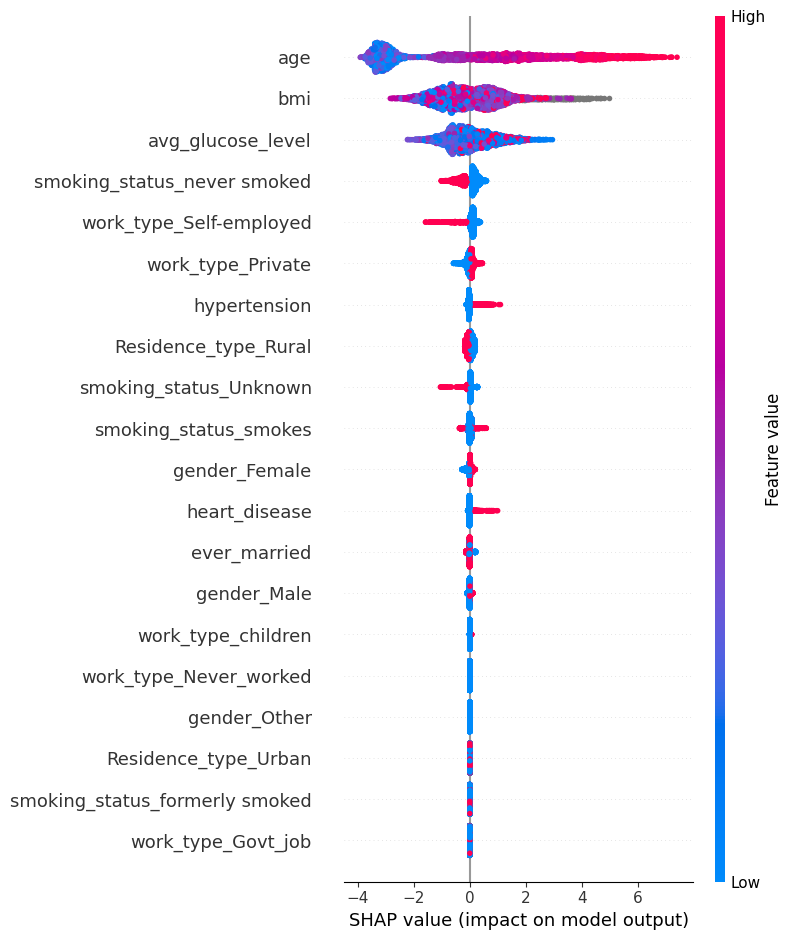

<IPython.core.display.Javascript object>

In [146]:
# Assuming lgb1 is your trained LightGBM model
explainer_lgb1 = shap.TreeExplainer(lgb1)
shap_values_lgb1 = explainer_lgb1.shap_values(X)

# Force plot for prediction 4355
shap.initjs()
shap.force_plot(
    explainer_lgb1.expected_value[1], shap_values_lgb1[1][4355, :], X.iloc[4355, :]
)

# Summary plot of feature importance
shap.summary_plot(shap_values_lgb1[1], X)

# Interaction summary plot
shap_interaction_values_lgb1 = explainer_lgb1.shap_interaction_values(X)


In [149]:
index_to_explain = (
    4355  # Change this to the index of the prediction you want to explain
)
force_plot = shap.force_plot(
    explainer_lgb1.expected_value,
    shap_values[index_to_explain, :],
    X.iloc[index_to_explain, :],
)

force_plot

<IPython.core.display.Javascript object>

In [150]:
index_to_explain = 15  # Change this to the index of the prediction you want to explain
force_plot = shap.force_plot(
    explainer_lgb1.expected_value,
    shap_values[index_to_explain, :],
    X.iloc[index_to_explain, :],
)

force_plot

<IPython.core.display.Javascript object>

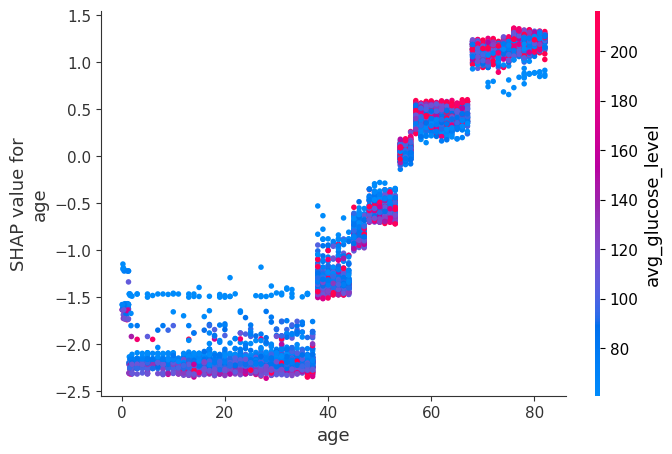

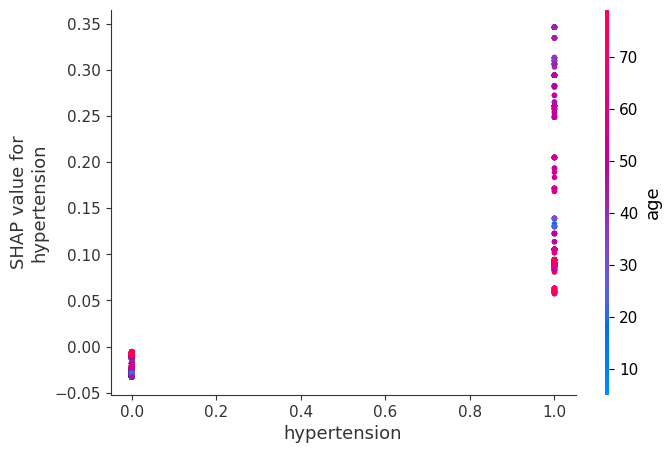

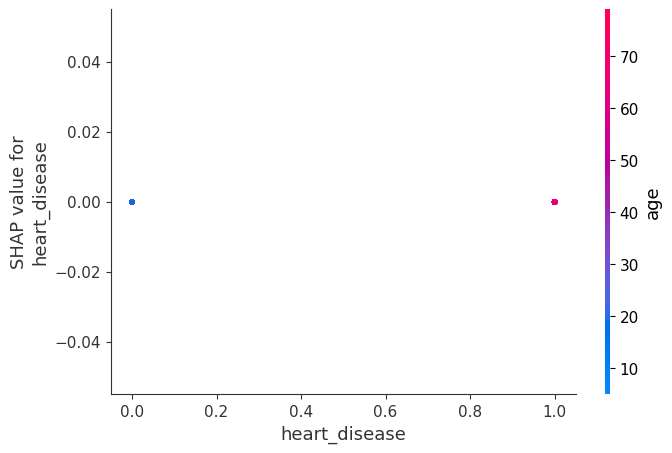

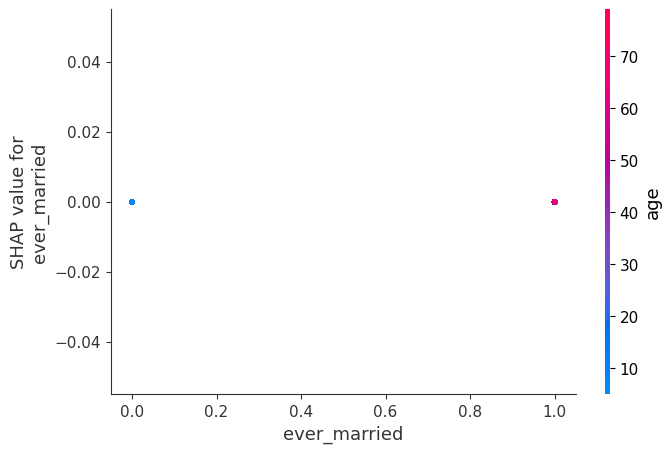

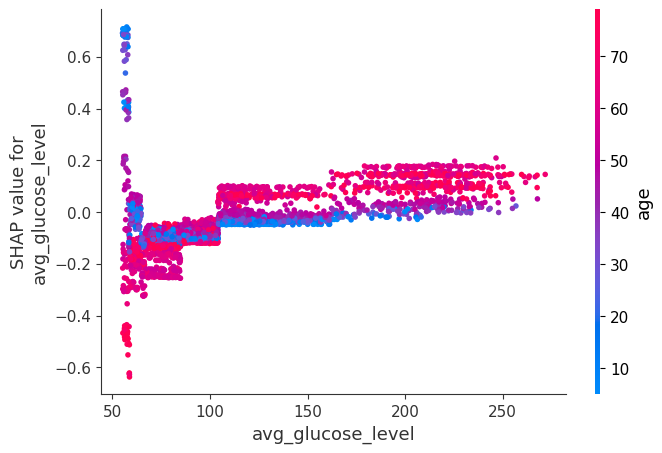

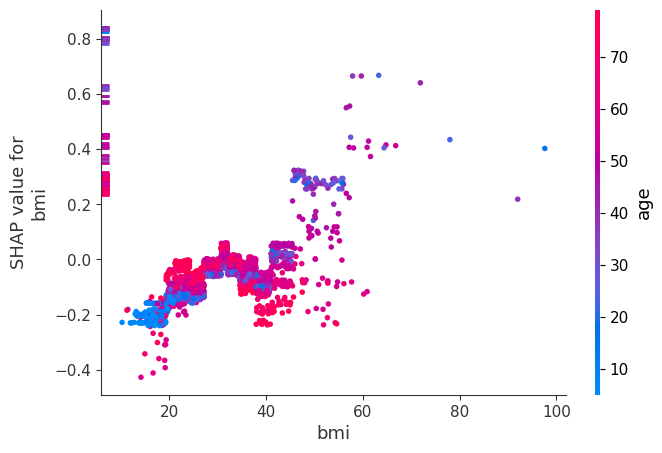

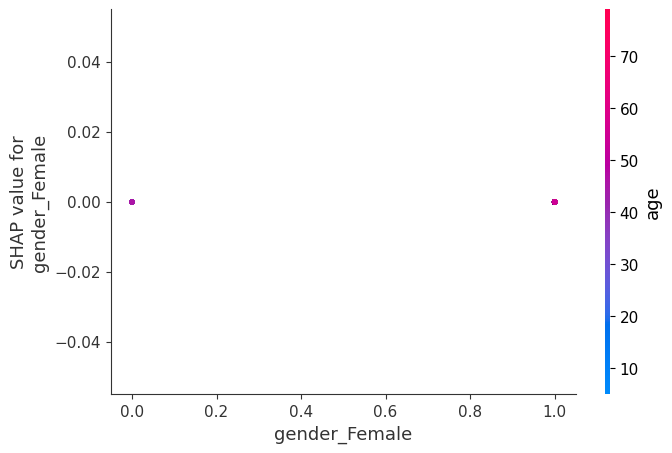

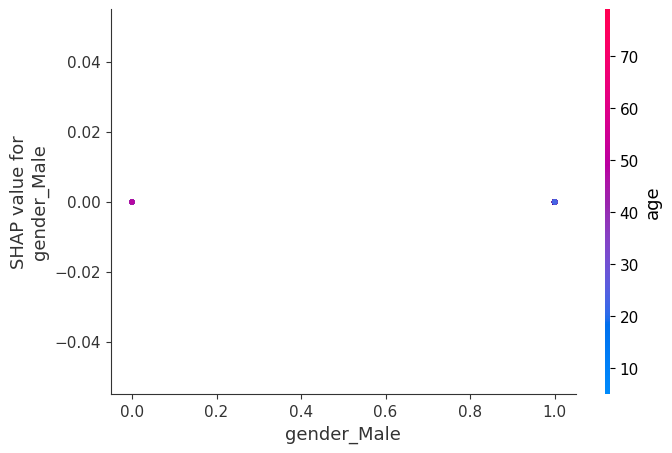

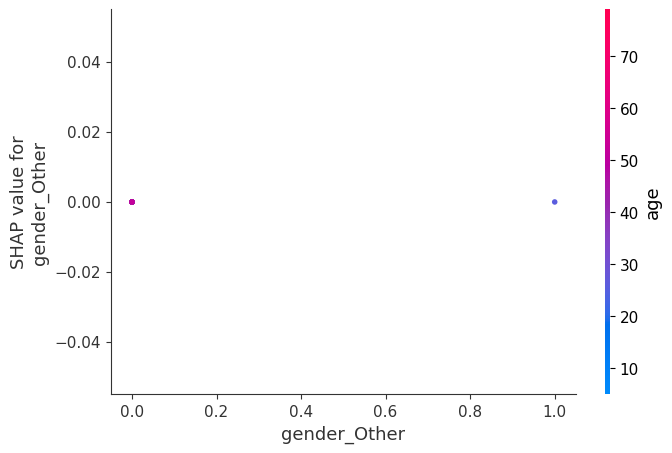

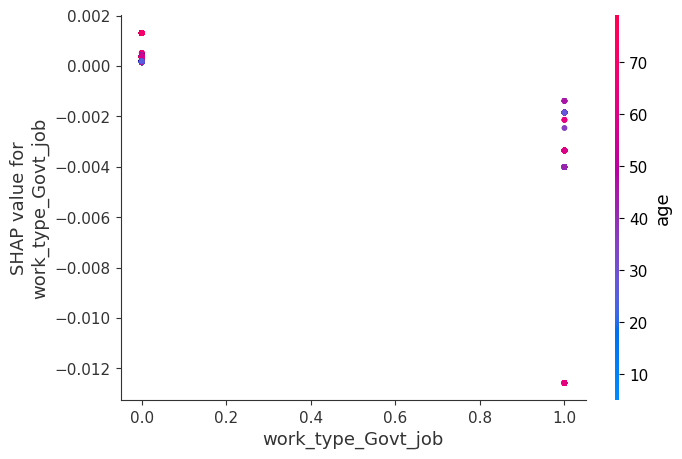

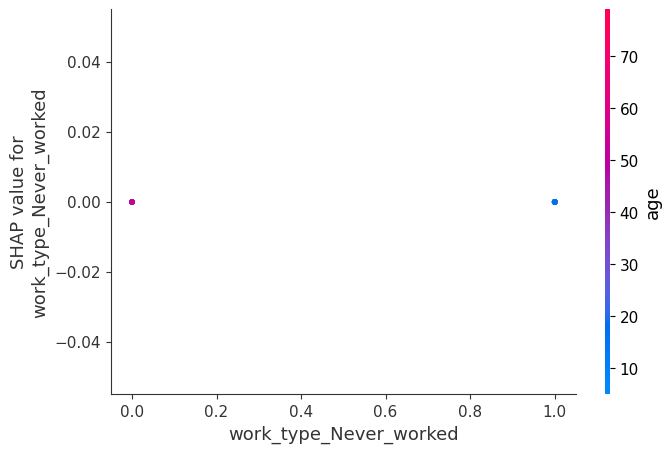

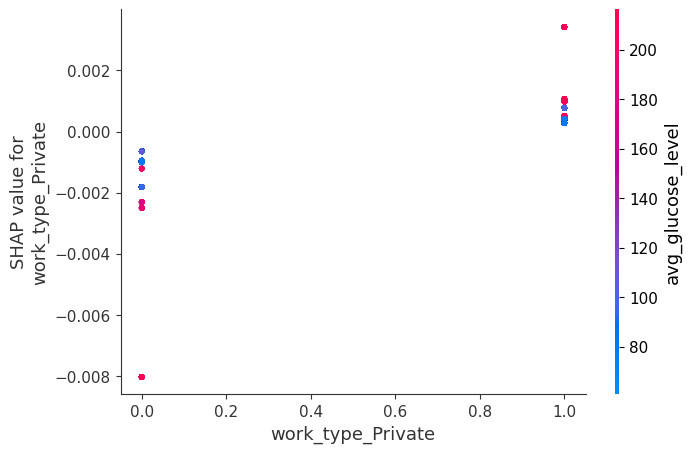

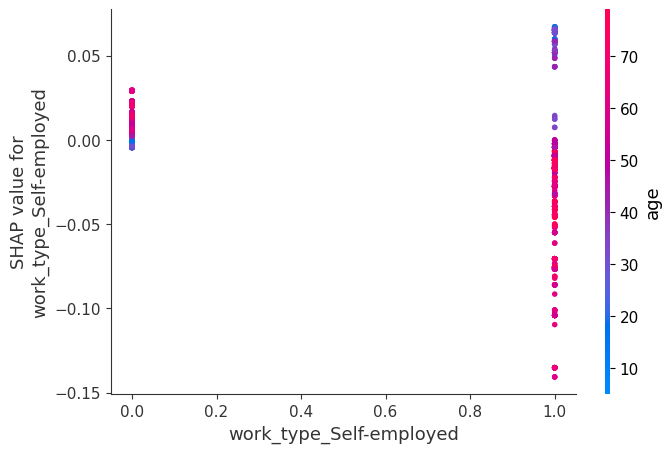

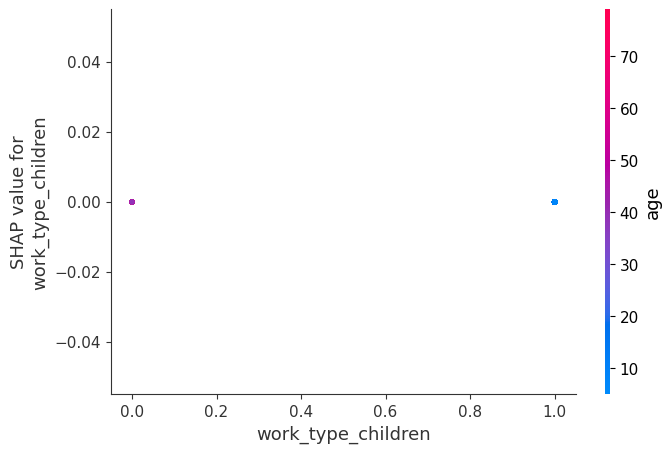

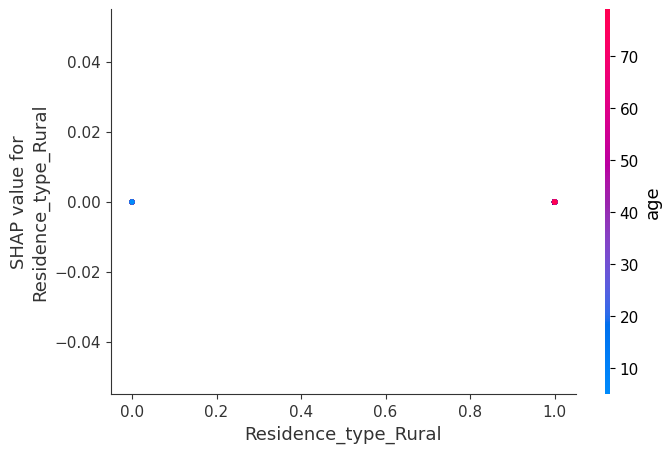

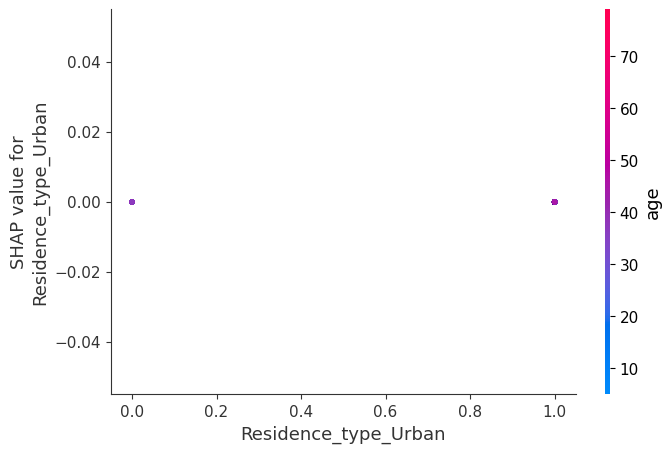

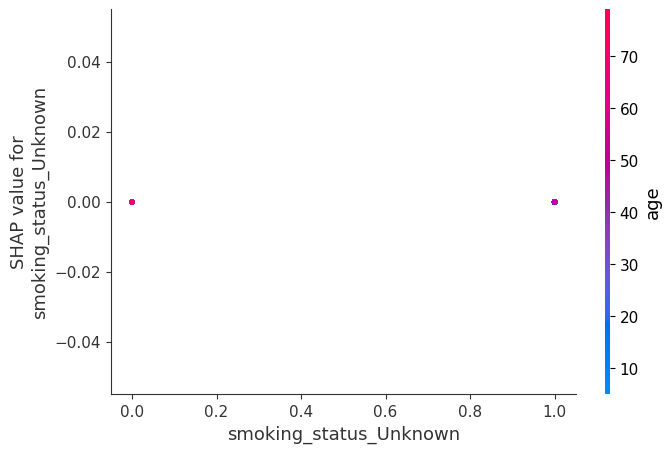

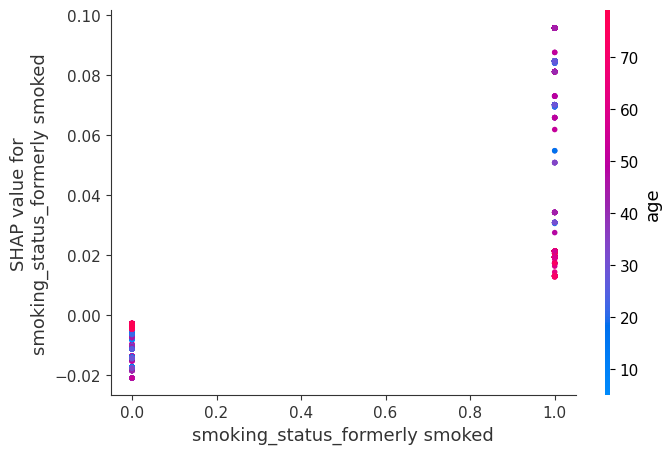

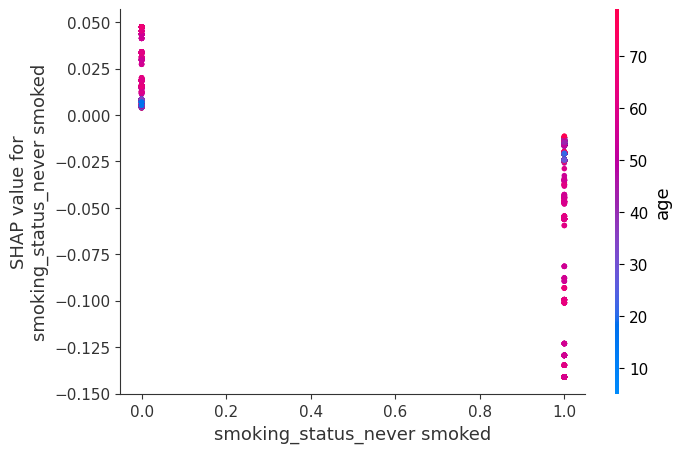

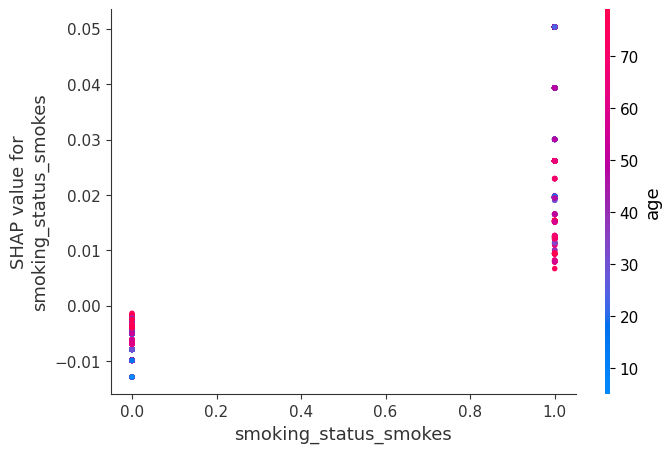

<IPython.core.display.Javascript object>

In [151]:
for name in X.columns:
    shap.dependence_plot(name, shap_values, X)

<Figure size 2000x1000 with 0 Axes>

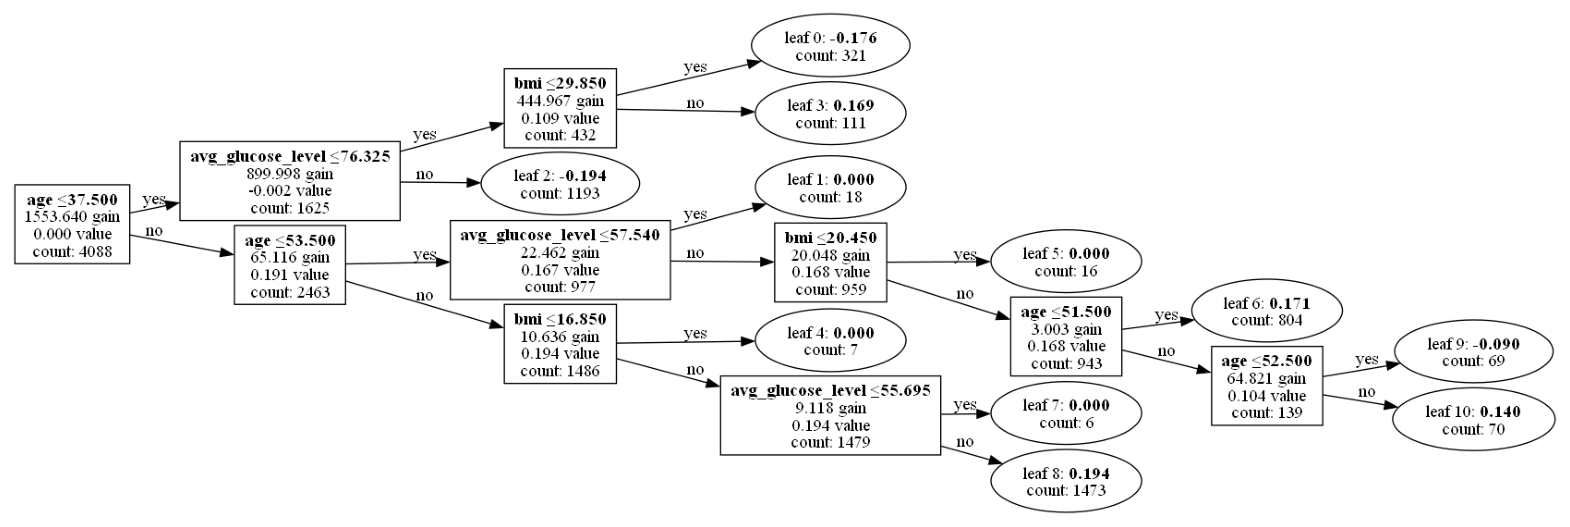

<IPython.core.display.Javascript object>

In [163]:
import lightgbm as lgb

# Assuming lgb1 is your trained LightGBM model
tree_index = 0  # Change this to the index of the tree you want to visualize

# Create the plot
plt.figure(figsize=(20, 10))
lgb.plot_tree(
    lgb1,
    tree_index=tree_index,
    figsize=(20, 10),
    show_info=["split_gain", "internal_value", "leaf_count", "internal_count"],
)
plt.show()

In [164]:
plt.savefig(f"LGBM_tree_visualization_{tree_index}.png")

<Figure size 640x480 with 0 Axes>

<IPython.core.display.Javascript object>

# Save of model and it's artifacts 

In [165]:
import pickle

model_filename = "lgb1_model.pkl"

# Save the model to a pickle file
with open(model_filename, "wb") as file:
    pickle.dump(lgb1, file)

print(f"LightGBM model saved to {model_filename}")

LightGBM model saved to lgb1_model.pkl


<IPython.core.display.Javascript object>

In [66]:
features = categorical_features + numerical_features

<IPython.core.display.Javascript object>

In [69]:
# Save the encoder
joblib.dump(encoder, "encoder.joblib")

# Save the LightGBM model
joblib.dump(lgb1, "lgb1_model.joblib")

joblib.dump(features,"features.joblib")

joblib.dump(categorical_features,"categorical_features.joblib")



['categorical_features.joblib']

<IPython.core.display.Javascript object>

In [71]:
!pip freeze > requirements.txt

<IPython.core.display.Javascript object>

# Conclusion

We have developed a Light GBM Classification model that can accurately predict stroke risk with a Recall of 0.964 on test data. This model can be used to identify individuals at high risk of stroke and to develop interventions to prevent stroke. The most important features found to be predictive of stroke risk were Age, BMI, Average glucose levels, Work type, and smoking status.

#### What could be improved 

* Could be gathered more data, with more valuable features
* Try to use more hyperparameters in tuning
* Would try to create new models without some features and chech it's performance